In [14]:
# третьяя версия скрипта. Попытка рандомно брать слайс данных и предсказывать время до землетрясения
# + обучать на слайсе который представляет собой данные между землетрясениями

In [16]:
import gc
import os
from os.path import join
import time
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from scipy import stats
from scipy.signal import hann
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.signal import convolve
from sklearn.svm import NuSVR, SVR
from catboost import CatBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold,StratifiedKFold, RepeatedKFold, TimeSeriesSplit
from bayes_opt import BayesianOptimization
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
from keras.layers import Dropout
from hurst import compute_Hc
from  sklearn.mixture import GaussianMixture as GM

warnings.filterwarnings("ignore")

pd.options.display.precision = 15

PATH = 'data/earthquakes'

In [17]:
def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]


def classic_sta_lta(x, length_sta, length_lta):
    sta = np.cumsum(x ** 2)
    # Convert to float
    sta = np.require(sta, dtype=np.float)
    # Copy for LTA
    lta = sta.copy()
    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta
    # Pad zeros
    sta[:length_lta - 1] = 0
    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny
    return sta / lta


def petrosian_fd(x):
    n = len(x)
    # Number of sign changes in the first derivative of the signal
    diff = np.ediff1d(x)
    N_delta = (diff[1:-1] * diff[0:-2] < 0).sum()
    return np.log10(n) / (np.log10(n) + np.log10(n / (n + 0.4 * N_delta)))


def der_sign_changes(x):
    diff = np.ediff1d(x)
    return (diff[1:-1] * diff[0:-2] < 0).sum() / len(x)


def sec_der_sign_changes(x):
    diff = np.ediff1d(x)
    diff2 = np.ediff1d(diff)
    return (diff2[1:-1] * diff2[0:-2] < 0).sum() / len(x)


def sec_der_mean(x):
    diff = np.ediff1d(x)
    diff2 = np.ediff1d(diff)
    return (diff2[1:-1] * diff2[0:-2]).mean()


def hurst_exp(x):
    arr = x - x.min() + 1
    H, c, data = compute_Hc(arr.values, kind='price', simplified=True)
    return H, c


# def apply_convolutional():
    


def create_features(seg_id, seg, X):
    xc = pd.Series(seg['acoustic_data'].values)
    zc = np.fft.fft(xc)
    
    # my
    X.loc[seg_id, 'my_petrosian_fd'] = petrosian_fd(xc)
    X.loc[seg_id, 'my_der_sign_changes'] = der_sign_changes(xc)
    X.loc[seg_id, 'my_sec_der_sign_changes'] = sec_der_sign_changes(xc)
    X.loc[seg_id, 'my_sec_der_mean'] = sec_der_mean(xc)
    
    # quite slowly
#     hurst = hurst_exp(xc)
#     X.loc[seg_id, 'my_hurst_h'] = hurst[0]
#     X.loc[seg_id, 'my_hurst_c'] = hurst[1]
    #
    
    X.loc[seg_id, 'mean'] = xc.mean()
    X.loc[seg_id, 'std'] = xc.std()
    X.loc[seg_id, 'max'] = xc.max()
    X.loc[seg_id, 'min'] = xc.min()
    
    #FFT transform values
    realFFT = np.real(zc)
    imagFFT = np.imag(zc)

    X.loc[seg_id, 'Rmean'] = realFFT.mean()
    X.loc[seg_id, 'Rstd'] = realFFT.std()
    X.loc[seg_id, 'Rmax'] = realFFT.max()
    X.loc[seg_id, 'Rmin'] = realFFT.min()
    X.loc[seg_id, 'Imean'] = imagFFT.mean()
    X.loc[seg_id, 'Istd'] = imagFFT.std()
    X.loc[seg_id, 'Imax'] = imagFFT.max()
    X.loc[seg_id, 'Imin'] = imagFFT.min()
    X.loc[seg_id, 'Rmean_last_5000'] = realFFT[-5000:].mean()
    X.loc[seg_id, 'Rstd_last_5000'] = realFFT[-5000:].std()
    X.loc[seg_id, 'Rmax_last_5000'] = realFFT[-5000:].max()
    X.loc[seg_id, 'Rmin_last_5000'] = realFFT[-5000:].min()
    X.loc[seg_id, 'Rmean_last_15000'] = realFFT[-15000:].mean()
    X.loc[seg_id, 'Rstd_last_15000'] = realFFT[-15000:].std()
    X.loc[seg_id, 'Rmax_last_15000'] = realFFT[-15000:].max()
    X.loc[seg_id, 'Rmin_last_15000'] = realFFT[-15000:].min()
    
    # start of mine
    X.loc[seg_id, 'Rmean_last_100'] = realFFT[-100:].mean()
    X.loc[seg_id, 'Rstd_last_100'] = realFFT[-100:].std()
    X.loc[seg_id, 'Rmax_last_100'] = realFFT[-100:].max()
    X.loc[seg_id, 'Rmin_last_100'] = realFFT[-100:].min()
    X.loc[seg_id, 'Imean_last_100'] = imagFFT[-100:].mean()
    X.loc[seg_id, 'Istd_last_100'] = imagFFT[-100:].std()
    X.loc[seg_id, 'Imax_last_100'] = imagFFT[-100:].max()
    X.loc[seg_id, 'Imin_last_100'] = imagFFT[-100:].min()
    
    # Я дошел до того, что строить больше фич по сигналу бесполезно, изменю немного параметры
    
#     X.loc[seg_id, 'Rmean_first_100'] = realFFT[:100].mean()
#     X.loc[seg_id, 'Rstd_first_100'] = realFFT[:100].std()
#     X.loc[seg_id, 'Rmax_first_100'] = realFFT[:100].max()
#     X.loc[seg_id, 'Rmin_first_100'] = realFFT[:100].min()
#     X.loc[seg_id, 'Imean_first_100'] = imagFFT[:100].mean()
#     X.loc[seg_id, 'Istd_first_100'] = imagFFT[:100].std()
#     X.loc[seg_id, 'Imax_first_100'] = imagFFT[:100].max()
#     X.loc[seg_id, 'Imin_first_100'] = imagFFT[:100].min()
    
    # start of added
#     X.loc[seg_id, 'Rmean_first_5000'] = realFFT[:5000].mean()
#     X.loc[seg_id, 'Rstd_first_5000'] = realFFT[:5000].std()
#     X.loc[seg_id, 'Rmax_first_5000'] = realFFT[:5000].max()
#     X.loc[seg_id, 'Rmin_first_5000'] = realFFT[:5000].min()
    
    ft_last_10000_rows = np.fft.fft(xc[-10000:])
    realFFT_last_10000_rows = np.real(ft_last_10000_rows)
    
    X.loc[seg_id, '10000_rows_Rmean_last_1000'] = realFFT_last_10000_rows[-1000:].mean()
    X.loc[seg_id, '10000_rows_Rstd_last_1000'] = realFFT_last_10000_rows[-1000:].std()
    X.loc[seg_id, '10000_rows_Rmax_last_1000'] = realFFT_last_10000_rows[-1000:].max()
    X.loc[seg_id, '10000_rows_Rmin_last_1000'] = realFFT_last_10000_rows[-1000:].min()
    
    X.loc[seg_id, '10000_rows_Rmean_first_1000'] = realFFT_last_10000_rows[:1000].mean()
    X.loc[seg_id, '10000_rows_Rstd_first_1000'] = realFFT_last_10000_rows[:1000].std()
    X.loc[seg_id, '10000_rows_Rmax_first_1000'] = realFFT_last_10000_rows[:1000].max()
    X.loc[seg_id, '10000_rows_Rmin_first_1000'] = realFFT_last_10000_rows[:1000].min()
    
    gm = GM(n_components=3, covariance_type='full')
    gm.fit(xc[-10000:].reshape(-1,1))
    for i in [0,1,2]:
        X.loc[seg_id, 'my_gm_mean_%s' % i] = gm.means_[i]
        X.loc[seg_id, 'my_gm_cov_%s' % i] = gm.covariances_[i]  
        
    gm = GM(n_components=3, covariance_type='full')
    gm.fit(xc.reshape(-1,1))
    for i in [0,1,2]:
        X.loc[seg_id, 'my_ALL_gm_mean_%s' % i] = gm.means_[i]
        X.loc[seg_id, 'my_ALL_gm_cov_%s' % i] = gm.covariances_[i]
        
    gm = GM(n_components=3, covariance_type='full')
    gm.fit(realFFT[-5000:].reshape(-1,1))
    for i in [0,1,2]:
        X.loc[seg_id, 'my_R_gm_mean_%s' % i] = gm.means_[i]
        X.loc[seg_id, 'my_R_gm_R_cov_%s' % i] = gm.covariances_[i] 
    # end of added
    
    # end of mine
    
    el = np.diff(xc) / xc[:-1]
    el = el[~np.isnan(el) & ~np.isinf(el)]
    X.loc[seg_id, 'mean_change_rate'] = np.mean(el)
    
    X.loc[seg_id, 'mean_change_abs'] = np.mean(np.diff(xc))
    X.loc[seg_id, 'abs_max'] = np.abs(xc).max()
    X.loc[seg_id, 'abs_min'] = np.abs(xc).min()
    
    X.loc[seg_id, 'std_first_50000'] = xc[:50000].std()
    X.loc[seg_id, 'std_last_50000'] = xc[-50000:].std()
    X.loc[seg_id, 'std_first_10000'] = xc[:10000].std()
    X.loc[seg_id, 'std_last_10000'] = xc[-10000:].std()
    
    X.loc[seg_id, 'avg_first_50000'] = xc[:50000].mean()
    X.loc[seg_id, 'avg_last_50000'] = xc[-50000:].mean()
    X.loc[seg_id, 'avg_first_10000'] = xc[:10000].mean()
    X.loc[seg_id, 'avg_last_10000'] = xc[-10000:].mean()
    
    X.loc[seg_id, 'min_first_50000'] = xc[:50000].min()
    X.loc[seg_id, 'min_last_50000'] = xc[-50000:].min()
    X.loc[seg_id, 'min_first_10000'] = xc[:10000].min()
    X.loc[seg_id, 'min_last_10000'] = xc[-10000:].min()
    
    X.loc[seg_id, 'max_first_50000'] = xc[:50000].max()
    X.loc[seg_id, 'max_last_50000'] = xc[-50000:].max()
    X.loc[seg_id, 'max_first_10000'] = xc[:10000].max()
    X.loc[seg_id, 'max_last_10000'] = xc[-10000:].max()
    
    X.loc[seg_id, 'max_to_min'] = xc.max() / np.abs(xc.min())
    X.loc[seg_id, 'max_to_min_diff'] = xc.max() - np.abs(xc.min())
    X.loc[seg_id, 'count_big'] = len(xc[np.abs(xc) > 500])
    X.loc[seg_id, 'sum'] = xc.sum()
    
    # my update
    el = np.diff(xc[:50000]) / xc[:50000][:-1]
    el = el[~np.isnan(el) & ~np.isinf(el)]
    X.loc[seg_id, 'mean_change_rate_first_50000'] = np.mean(el)
    
    el = np.diff(xc[-50000:]) / xc[-50000:][:-1]
    el = el[~np.isnan(el) & ~np.isinf(el)]
    X.loc[seg_id, 'mean_change_rate_last_50000'] = np.mean(el)
    
    el = np.diff(xc[:10000]) / xc[:10000][:-1]
    el = el[~np.isnan(el) & ~np.isinf(el)]
    X.loc[seg_id, 'mean_change_rate_first_10000'] = np.mean(el)
    
    el = np.diff(xc[-10000:]) / xc[-10000:][:-1]
    el = el[~np.isnan(el) & ~np.isinf(el)]
    X.loc[seg_id, 'mean_change_rate_last_10000'] = np.mean(el)
    
    X.loc[seg_id, 'q95'] = np.percentile(xc, 0.95)
    X.loc[seg_id, 'q99'] = np.percentile(xc, 0.99)
    X.loc[seg_id, 'q05'] = np.percentile(xc, 0.05)
    X.loc[seg_id, 'q01'] = np.percentile(xc, 0.01)
    
    X.loc[seg_id, 'abs_q95'] = np.percentile(np.abs(xc), 0.95)
    X.loc[seg_id, 'abs_q99'] = np.percentile(np.abs(xc), 0.99)
    X.loc[seg_id, 'abs_q05'] = np.percentile(np.abs(xc), 0.05)
    X.loc[seg_id, 'abs_q01'] = np.percentile(np.abs(xc), 0.01)
    
    X.loc[seg_id, 'trend'] = add_trend_feature(xc)
    X.loc[seg_id, 'abs_trend'] = add_trend_feature(xc, abs_values=True)
    X.loc[seg_id, 'abs_mean'] = np.abs(xc).mean()
    X.loc[seg_id, 'abs_std'] = np.abs(xc).std()
    
    X.loc[seg_id, 'mad'] = xc.mad()
    X.loc[seg_id, 'kurt'] = xc.kurtosis()
    X.loc[seg_id, 'skew'] = xc.skew()
    X.loc[seg_id, 'med'] = xc.median()
    
    X.loc[seg_id, 'Hilbert_mean'] = np.abs(hilbert(xc)).mean()
    X.loc[seg_id, 'Hann_window_mean'] = (convolve(xc, hann(150), mode='same') / sum(hann(150))).mean()
    X.loc[seg_id, 'classic_sta_lta1_mean'] = classic_sta_lta(xc, 500, 10000).mean()
    X.loc[seg_id, 'classic_sta_lta2_mean'] = classic_sta_lta(xc, 5000, 100000).mean()
    X.loc[seg_id, 'classic_sta_lta3_mean'] = classic_sta_lta(xc, 3333, 6666).mean()
    X.loc[seg_id, 'classic_sta_lta4_mean'] = classic_sta_lta(xc, 10000, 25000).mean()
    X.loc[seg_id, 'Moving_average_700_mean'] = xc.rolling(window=700).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_1500_mean'] = xc.rolling(window=1500).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_3000_mean'] = xc.rolling(window=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_6000_mean'] = xc.rolling(window=6000).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    X.loc[seg_id, 'exp_Moving_average_300_mean'] = (ewma(xc, span=300).mean()).mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_3000_mean'] = ewma(xc, span=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_30000_mean'] = ewma(xc, span=6000).mean().mean(skipna=True)
    no_of_std = 2
    X.loc[seg_id, 'MA_700MA_std_mean'] = xc.rolling(window=700).std().mean()
    X.loc[seg_id,'MA_700MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X.loc[seg_id,'MA_700MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X.loc[seg_id, 'MA_400MA_std_mean'] = xc.rolling(window=400).std().mean()
    X.loc[seg_id,'MA_400MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X.loc[seg_id,'MA_400MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X.loc[seg_id, 'MA_1000MA_std_mean'] = xc.rolling(window=1000).std().mean()
    
    X.loc[seg_id, 'iqr'] = np.subtract(*np.percentile(xc, [75, 25]))
    X.loc[seg_id, 'q999'] = np.percentile(xc,0.999)
    X.loc[seg_id, 'q001'] = np.percentile(xc,0.001)
    X.loc[seg_id, 'ave10'] = stats.trim_mean(xc, 0.1)
    
    for windows in [10, 100, 1000]:
        x_roll_std = xc.rolling(windows).std().dropna().values
        x_roll_mean = xc.rolling(windows).mean().dropna().values
        
        # some of my rolling features
        X.loc[seg_id, 'std_to_mean' + str(windows)] = (x_roll_std[x_roll_mean != 0] / x_roll_mean[x_roll_mean != 0]).mean()
        
        
        X.loc[seg_id, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X.loc[seg_id, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X.loc[seg_id, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X.loc[seg_id, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X.loc[seg_id, 'q01_roll_std_' + str(windows)] = np.percentile(x_roll_std, 0.01)
        X.loc[seg_id, 'q05_roll_std_' + str(windows)] = np.percentile(x_roll_std, 0.05)
        X.loc[seg_id, 'q95_roll_std_' + str(windows)] = np.percentile(x_roll_std, 0.95)
        X.loc[seg_id, 'q99_roll_std_' + str(windows)] = np.percentile(x_roll_std, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))

        el = np.diff(x_roll_std) / x_roll_std[:-1]
        el = el[~np.isnan(el) & ~np.isinf(el)]
        X.loc[seg_id, 'av_change_rate_roll_std_' + str(windows)] = np.mean(el)
        X.loc[seg_id, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X.loc[seg_id, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X.loc[seg_id, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X.loc[seg_id, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X.loc[seg_id, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X.loc[seg_id, 'q01_roll_mean_' + str(windows)] = np.percentile(x_roll_mean, 0.01)
        X.loc[seg_id, 'q05_roll_mean_' + str(windows)] = np.percentile(x_roll_mean, 0.05)
        X.loc[seg_id, 'q95_roll_mean_' + str(windows)] = np.percentile(x_roll_mean, 0.95)
        X.loc[seg_id, 'q99_roll_mean_' + str(windows)] = np.percentile(x_roll_mean, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
    
        el = np.diff(x_roll_mean) / x_roll_mean[:-1]
        el = el[~np.isnan(el) & ~np.isinf(el)]
        X.loc[seg_id, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(el)
        X.loc[seg_id, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

In [18]:
%%time
train_df = pd.read_csv(join(PATH,'train.csv'), dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})
train_df.head(10)

Wall time: 2min 44s


In [19]:
# rows = 150000
# segments = int(np.floor(train_df.shape[0] / rows))
# total_mean = train_df['acoustic_data'].mean()
# total_std = train_df['acoustic_data'].std()
# total_max = train_df['acoustic_data'].max()
# total_min = train_df['acoustic_data'].min()
# total_sum = train_df['acoustic_data'].sum()
# total_abs_sum = np.abs(train_df['acoustic_data']).sum()

In [24]:

rows = 150000
# segments = int(np.floor(train_df.shape[0] / rows))

segments = 10000
train_X = pd.DataFrame(index=range(segments), dtype=np.float64)
train_y = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['time_to_failure'])
print("Number of segments: ", segments)

state = 'random_slice'
for seg_id in tqdm(range(segments)):
    if state == 'random_slice':
        try:
            seq_start = np.random.randint(low=0, high=train_df.shape[0])
            seg = train_df.iloc[seq_start : seq_start + rows]
            create_features(seg_id, seg, train_X)
            train_y.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]
        except:
            print('Query was out of range')
    else:
        None
    
train_X.shape

Number of segments:  10000


HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

(10000, 195)

In [25]:
for col in train_X.columns:
    if train_X[(np.isfinite(train_X[col]))][col].count() != 10000:
        print(train_X[(np.isfinite(train_X[col]))][col].count(), col)



10000 my_petrosian_fd
10000 my_der_sign_changes
10000 my_sec_der_sign_changes
10000 my_sec_der_mean
10000 mean
10000 std
10000 max
10000 min
10000 Rmean
10000 Rstd
10000 Rmax
10000 Rmin
10000 Imean
10000 Istd
10000 Imax
10000 Imin
10000 Rmean_last_5000
10000 Rstd_last_5000
10000 Rmax_last_5000
10000 Rmin_last_5000
10000 Rmean_last_15000
10000 Rstd_last_15000
10000 Rmax_last_15000
10000 Rmin_last_15000
10000 Rmean_last_100
10000 Rstd_last_100
10000 Rmax_last_100
10000 Rmin_last_100
10000 Imean_last_100
10000 Istd_last_100
10000 Imax_last_100
10000 Imin_last_100
10000 10000_rows_Rmean_last_1000
10000 10000_rows_Rstd_last_1000
10000 10000_rows_Rmax_last_1000
10000 10000_rows_Rmin_last_1000
10000 10000_rows_Rmean_first_1000
10000 10000_rows_Rstd_first_1000
10000 10000_rows_Rmax_first_1000
10000 10000_rows_Rmin_first_1000
10000 my_gm_mean_0
10000 my_gm_cov_0
10000 my_gm_mean_1
10000 my_gm_cov_1
10000 my_gm_mean_2
10000 my_gm_cov_2
10000 my_ALL_gm_mean_0
10000 my_ALL_gm_cov_0
10000 my_ALL_gm

In [26]:
scaler = StandardScaler()
scaler.fit(train_X)
scaled_train_X = pd.DataFrame(scaler.transform(train_X), columns=train_X.columns)

In [27]:
submission = pd.read_csv(join(PATH, 'sample_submission.csv'), index_col='seg_id')
test_X = pd.DataFrame(columns=train_X.columns, dtype=np.float64, index=submission.index)

submission.shape, test_X.shape

((2624, 1), (2624, 195))

In [28]:
for seg_id in tqdm(test_X.index):
    seg = pd.read_csv(join(PATH, 'test/%s.csv' % seg_id))
    create_features(seg_id, seg, test_X)
    
scaled_test_X = pd.DataFrame(scaler.transform(test_X), columns=test_X.columns)

HBox(children=(IntProgress(value=0, max=2624), HTML(value='')))

In [33]:
n_fold = 5
# StratifiedKFold, TimeSeriesSplit, LeaveOneGroupOut
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
train_columns = scaled_train_X.columns.values

params = {'num_leaves': 51,
         'min_data_in_leaf': 10, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.001,
         "boosting": "gbdt",
         "feature_fraction": 0.91,
         "bagging_freq": 1,
         "bagging_fraction": 0.91,
         "bagging_seed": 42,
         "metric": 'mae',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": -1,
         "random_state": 42}

oof = np.zeros(len(scaled_train_X))
predictions = np.zeros(len(scaled_test_X))
feature_importance_df = pd.DataFrame()

maes = []
for fold_, (trn_idx, val_idx) in enumerate(folds.split(scaled_train_X,train_y.values)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr, X_val = scaled_train_X.iloc[trn_idx], scaled_train_X.iloc[val_idx]
    y_tr, y_val = train_y.iloc[trn_idx].values.reshape(-1), train_y.iloc[val_idx].values.reshape(-1)
    
    model = lgb.LGBMRegressor(**params, n_estimators = 20000, n_jobs = -1)
    model.fit(X_tr, 
              y_tr, 
              eval_set=[(X_tr, y_tr), (X_val, y_val)], 
              eval_metric='mae',
              verbose=1000, 
              early_stopping_rounds=200)
    oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    curr_mae = mean_absolute_error(oof[val_idx], y_val)
    maes.append(curr_mae)
    
    predictions += model.predict(scaled_test_X, num_iteration=model.best_iteration_) / folds.n_splits
    
print('MAE: mean - %s, min - %s, max - %s' % (np.mean(maes), min(maes), max(maes)))
# MAE: mean - 2.0930624969988303, min - 2.021386530812544, max - 2.1304048517804426

fold 0
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 2.02225	valid_1's l1: 2.17148
[2000]	training's l1: 1.70098	valid_1's l1: 1.97035
[3000]	training's l1: 1.53798	valid_1's l1: 1.90167
[4000]	training's l1: 1.42195	valid_1's l1: 1.86737
[5000]	training's l1: 1.32993	valid_1's l1: 1.84516
[6000]	training's l1: 1.25047	valid_1's l1: 1.82802
[7000]	training's l1: 1.17634	valid_1's l1: 1.81183
[8000]	training's l1: 1.1083	valid_1's l1: 1.7977
[9000]	training's l1: 1.04495	valid_1's l1: 1.78468
[10000]	training's l1: 0.985694	valid_1's l1: 1.77322
[11000]	training's l1: 0.929556	valid_1's l1: 1.76229
[12000]	training's l1: 0.877238	valid_1's l1: 1.75223
[13000]	training's l1: 0.828388	valid_1's l1: 1.74356
[14000]	training's l1: 0.782479	valid_1's l1: 1.73538
[15000]	training's l1: 0.739015	valid_1's l1: 1.72796
[16000]	training's l1: 0.698643	valid_1's l1: 1.72135
[17000]	training's l1: 0.66095	valid_1's l1: 1.7154
[18000]	training's l1: 0.624924	va

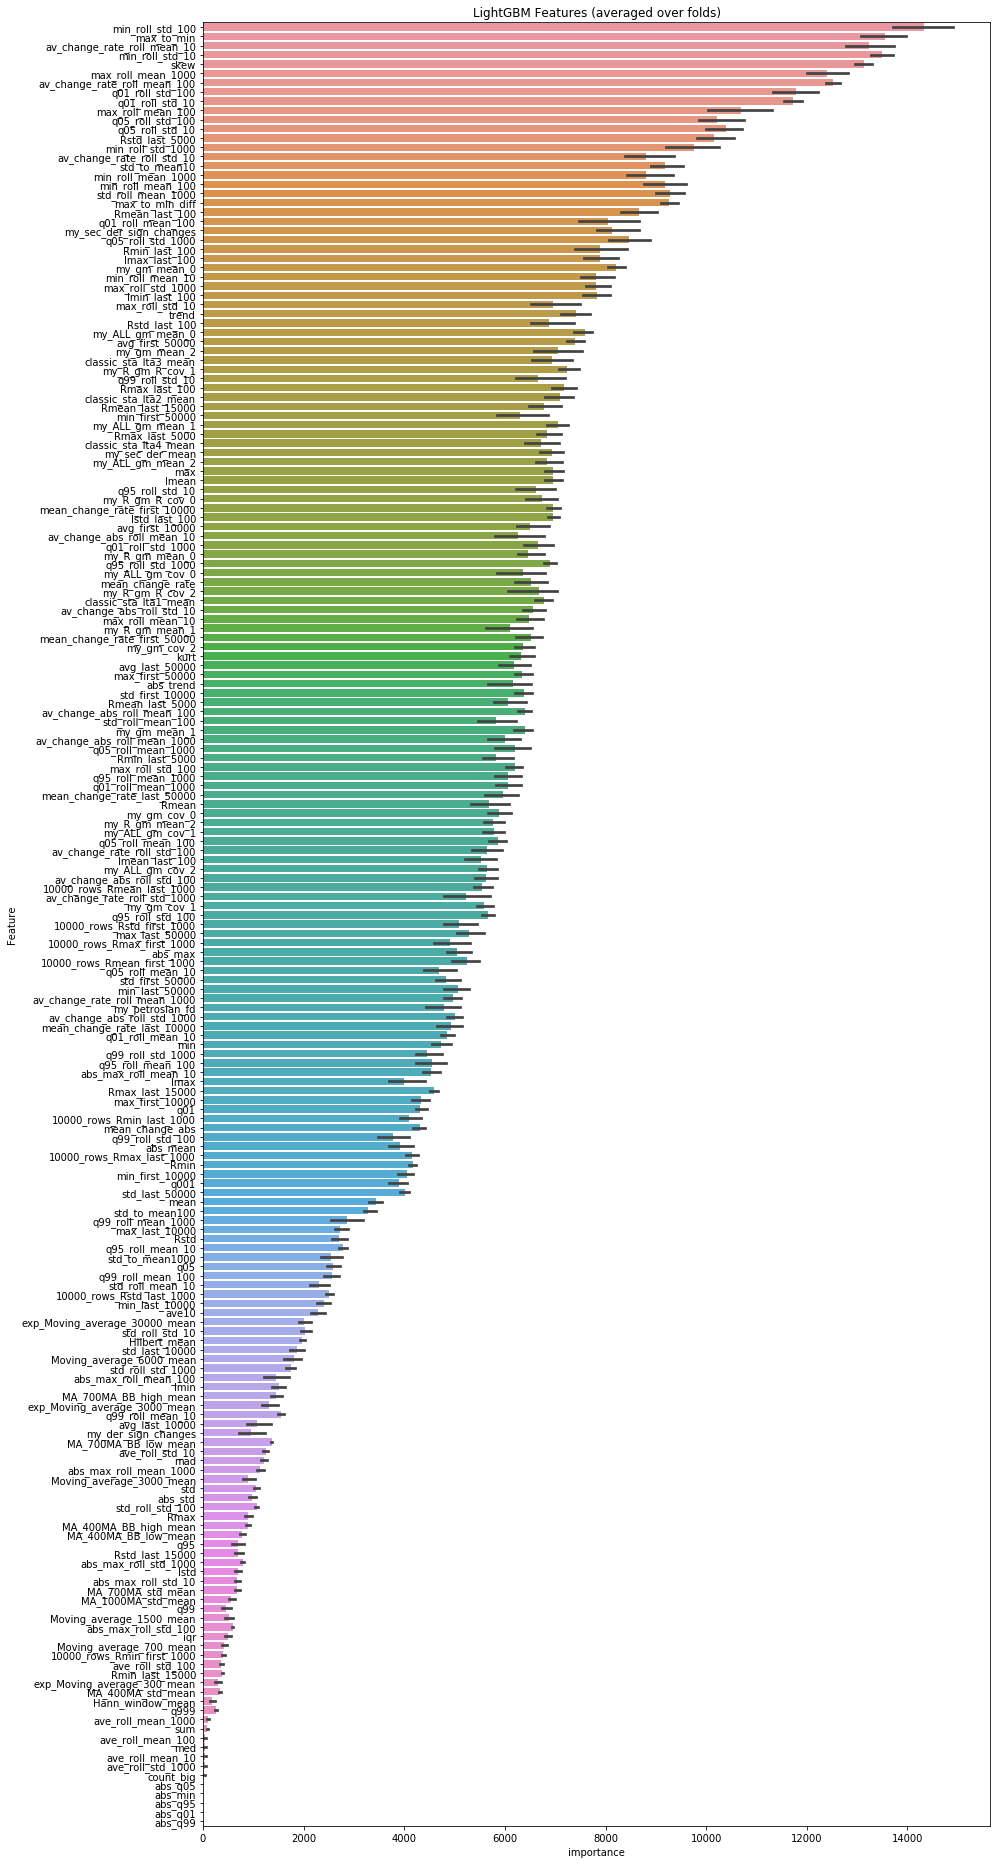

In [34]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:200].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [35]:
submission.time_to_failure = predictions
submission.to_csv(join(PATH, 'submission.csv'),index=True)

In [36]:
del train_df
gc.collect()

NameError: name 'train_df' is not defined

# Neural Network Recurrent

In [14]:
import pandas as pd
import pyarrow.parquet as pq # Used to read the data
import os 
import numpy as np
from keras.layers import * # Keras is the most friendly Neural Network library, this Kernel use a lot of layers classes
from keras.models import *
from tqdm import tqdm_notebook as tqdm # Processing time measurement
from sklearn.model_selection import train_test_split 
from keras import backend as K # The backend give us access to tensorflow operations and allow us to create the Attention class
from keras import optimizers # Allow us to access the Adam class to modify some parameters
from sklearn.model_selection import GridSearchCV, StratifiedKFold # Used to use Kfold to train our model
from keras.callbacks import * # This object helps the model to train in a smarter way, avoiding overfitting
from keras import activations
from keras import regularizers
from keras import initializers
from keras import constraints
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from numba import jit
from math import log, floor
from sklearn.neighbors import KDTree
from scipy.signal import periodogram, welch
from keras.engine import Layer
from keras.engine import InputSpec
from keras.objectives import categorical_crossentropy
from keras.objectives import sparse_categorical_crossentropy
import tensorflow as tf
import pywt
from statsmodels.robust import mad
from scipy import signal
import gc
from scipy.optimize import leastsq
import sympy 
from contextlib import contextmanager
import time
import pickle
from tensorflow import metrics
# import gplearn
# from gplearn.genetic import SymbolicTransformer
# from gplearn.functions import make_function


class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim
    
    
def model_lstm(input_shape, feat_shape):
    inp = Input(shape=(input_shape[1], input_shape[2],))
    feat = Input(shape=(feat_shape[1],))

    bi_lstm = Bidirectional(LSTM(128, return_sequences=True), merge_mode='concat')(inp)
    bi_gru = Bidirectional(GRU(64, return_sequences=True), merge_mode='concat')(bi_lstm)
    
    attention = Attention(input_shape[1])(bi_gru)
    
    x = concatenate([attention, feat], axis=1)
    x = Dense(64, activation="relu")(x)
    x = Dense(1)(x)
    
    model = Model(inputs=[inp, feat], outputs=x)
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
    print(model.summary())
    return model
    
    
def signal_reducing(signal, n_dim=150):
    signal_size = len(signal)
    slice_size = int(signal_size / n_dim)
    signal_reduced = []
    
    for i in range(0, signal_size, slice_size):
        signal_slice = signal[i:i + slice_size]

        mean = signal_slice.mean()
        std = signal_slice.std()
        std_top = mean + std 
        std_bot = mean - std
        percentiles = np.percentile(signal_slice, [0, 1, 25, 50, 75, 99, 100]) 
        max_range = percentiles[-1] - percentiles[0] 

        rel_percentile = percentiles - mean 
        bin_stat = np.concatenate([np.asarray([mean, std, std_top, std_bot, max_range]), percentiles, rel_percentile])
        signal_reduced.append(bin_stat)
    
    scaler = StandardScaler()
    signal_reduced = scaler.fit_transform(np.array(signal_reduced))
    return signal_reduced


def feature_extraction(PATH, n_dim, set_type='train'):
        if set_type == 'train':
            train_df = pd.read_csv(join(PATH,'train.csv'), 
                                   dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})
            rows = 150000
            segments = int(np.floor(train_df.shape[0] / rows))
            # segments = 50
            
            train_X = pd.DataFrame(index=range(segments), dtype=np.float64)
            train_y = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['time_to_failure'])
            train_signals_reduced = []
            
            for seg_id in tqdm(range(segments)):
                seg = train_df.iloc[seg_id*rows:seg_id*rows+rows]
                create_features(seg_id, seg, train_X)
                train_signals_reduced.append(signal_reducing(seg.acoustic_data, n_dim=n_dim))
                train_y.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]
                
            scaler = StandardScaler()
            train_X = scaler.fit_transform(train_X.values)
            
            return train_X, np.array(train_signals_reduced), train_y.values.reshape(-1)
        elif set_type == 'test': 
            submission = pd.read_csv(join(PATH, 'sample_submission.csv'), index_col='seg_id')
            test_X = pd.DataFrame(dtype=np.float64, index=submission.index)
            test_signals_reduced = []
            
            for seg_id in tqdm(test_X.index):
                seg = pd.read_csv(join(PATH, 'test/%s.csv' % seg_id))
                create_features(seg_id, seg, test_X)
                test_signals_reduced.append(signal_reducing(seg.acoustic_data, n_dim=n_dim))
            
            scaler = StandardScaler()
            test_X = scaler.fit_transform(test_X.values)
            return test_X, np.array(test_signals_reduced)
            
        
            
n_dim = 200           
train_X, train_X_reduced, train_Y = feature_extraction(PATH, n_dim=n_dim, set_type='train') 
test_X, test_X_reduced = feature_extraction(PATH, n_dim=n_dim, set_type='test')
print(train_X.shape, train_X_reduced.shape, train_Y.shape) 
print(test_X.shape, test_X_reduced.shape)            
            
            

HBox(children=(IntProgress(value=0, max=4194), HTML(value='')))

HBox(children=(IntProgress(value=0, max=2624), HTML(value='')))


(4194, 177) (4194, 200, 19) (4194,)
(2624, 177) (2624, 200, 19)


In [15]:
N_SPLITS = 5

splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).
              split(train_X_reduced, train_Y.astype(int)))
preds_val = []
to_kaggle_values = []
y_val = []
maes = []
for idx, (train_idx, val_idx) in tqdm(enumerate(splits)):
    K.clear_session()
    print("Beginning fold {}".format(idx+1))
    
    train_stat, train_seq = train_X[train_idx], train_X_reduced[train_idx]
    test_stat, test_seq = train_X[val_idx], train_X_reduced[val_idx]
    train_y, test_y = train_Y[train_idx], train_Y[val_idx]

    model = model_lstm(train_X_reduced.shape, train_X.shape)

    model.fit([train_seq, train_stat], 
              train_y, 
              batch_size=128, 
              epochs=2,
              verbose=0,
              validation_data=([test_seq, test_stat], test_y)
             )
    
    to_kaggle_values.append(model.predict([test_X_reduced, test_X], batch_size=512))
    
    curr_mae = mean_absolute_error(model.predict([test_seq, test_stat], batch_size=512), test_y)
    maes.append(curr_mae)
    
to_kaggle_values = np.asarray(to_kaggle_values).mean(axis=0)

print('MAE: mean - %s, min - %s, max - %s' % (np.mean(maes), min(maes), max(maes)))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Beginning fold 1
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 19)      0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 200, 256)     151552      input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 200, 128)     123264      bidirectional_1[0][0]            
__________________________________________________________________________________________________
attention_1 (Attention)         (None, 128)          328         bidirectional_2[0][0]            
____________________________________________________________________________________________

In [16]:
to_kaggle_values

array([[5.3274026],
       [4.8489537],
       [6.170375 ],
       ...,
       [3.5744457],
       [1.107457 ],
       [9.2854185]], dtype=float32)

In [17]:
submission.time_to_failure = to_kaggle_values
submission.to_csv(join(PATH, 'nn_submission.csv'),index=True)

# Convolutional neural network

In [ ]:
def create_cnn_model(shape):
    model = Sequential()

    model.add(Conv2D(256, kernel_size=5, activation=’relu’, input_shape=shape))
    model.add(Dropout(0.3))
    model.add(Conv2D(64, kernel_size=4, activation=’relu’))
    model.add(Dropout(0.3))
    model.add(Conv2D(16, kernel_size=3, activation=’relu’))
    model.add(Dropout(0.3))
    model.add(Conv2D(4, kernel_size=2, activation=’relu’))
    model.add(Flatten())
    model.add(Dense(1))
    
    return model

rows = 150000
model = create_cnn_model((np.sqrt(rows)+1, np.sqrt(rows)+1, 1))

# signal pushes to the model as:
# import numpy as np 
# rows = 150000
# shape = (int(np.sqrt(rows))+1, int(np.sqrt(rows))+1, 1)
# arr = np.random.randint(10, size=rows)
# adding = np.zeros((int(np.sqrt(rows)) + 1) * (int(np.sqrt(rows)) + 1) -150000)

# arr = np.concatenate([adding, arr])

# arr.reshape(shape).shape

# Bayessian optimization for lightGBM

In [50]:
# X = application_train.drop('TARGET', axis=1)
# y = application_train.TARGET

X = scaled_train_X
y = train_y.astype(int).values.reshape(-1)
print(X.shape , y.shape)
def bayes_parameter_opt_lgb(X, y, init_round, opt_round, n_folds, random_seed, n_estimators, learning_rate, output_process=False):
    # prepare data
    train_data = lgb.Dataset(data=X, label=y, free_raw_data=False)
    # parameters
    def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, 
                 min_split_gain, min_child_weight, max_bin, learning_rate):
        
        params = {
            'application':'binary',
            'num_iterations': n_estimators, 
            'learning_rate':learning_rate, 
            'early_stopping_round':100, 
            'metric':'mae'
        }
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        params['max_bin'] = int(max_bin)
        # params['min_data_in_leaf'] = min_data_in_leaf
        params['learning_rate'] = learning_rate
        
        cv_result = lgb.cv(params, 
                           train_data, 
                           nfold=n_folds, 
                           seed=random_seed, 
                           stratified=True, 
                           verbose_eval =200, 
                           metrics=['mae'])
        return max(cv_result['mae'])
    # range 
    lgbBO = BayesianOptimization(lgb_eval, 
                                 {
                                     'num_leaves': (24, 200),
                                     'feature_fraction': (0.1, 0.95),
                                     'bagging_fraction': (0.8, 1),
                                     'max_depth': (3, 10),
                                     'lambda_l1': (0, 5),
                                     'lambda_l2': (0, 3),
                                     'min_split_gain': (0.001, 0.1),
                                     'min_child_weight': (5, 50),
                                     'max_bin': (0, 500),
                                     # 'min_data_in_leaf ': (0, 100),
                                     'learning_rate': (0.001, 0.2)
                                 }, 
                                 random_state=0)
    # optimize
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    # output optimization process
    if output_process==True: 
        lgbBO.points_to_csv(join(PATH, 'bayes_opt_result.csv'))
    
    # return best parameters
    return lgbBO.res['max']['max_params']

opt_params = bayes_parameter_opt_lgb(X, 
                                     y, 
                                     init_round=5, 
                                     opt_round=10, 
                                     n_folds=5, 
                                     random_seed=6, 
                                     n_estimators=10000, 
                                     learning_rate=0.05)
opt_params

(4194, 154) (4194,)
|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | learni... |  max_bin  | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------------------
[200]	cv_agg's l1: 4.44032 + 0.0139645
[400]	cv_agg's l1: 4.43777 + 0.0146309
[600]	cv_agg's l1: 4.436 + 0.0151133
[800]	cv_agg's l1: 4.43564 + 0.0152221


KeyError: 'mae'

# GridSearchCV is very slow

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_curve, auc, accuracy_score)
from sklearn.model_selection import GridSearchCV


X = scaled_train_X
y = train_y.values.reshape(-1)


params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'binary',
          'nthread': 3, # Updated from nthread
          'num_leaves': 64,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 5,
          'reg_lambda': 10,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'binary_error'}

# Create parameters to search
gridParams = {
    'learning_rate': [0.001, 0.01, 0.1],
    'num_leaves': [50,75,100, 150],
    'boosting_type' : ['gbdt', 'dart', 'goss'],
    'max_bin': range(10, 500, 100),
    'lambda_l1': [1,2,3,4,5],
    'lambda_l2': [1,2,3,4,5],
    'min_split_gain': [0.001, 0.01, 0.1],
    'min_child_weight': range(5, 50, 10)
    }

# Create classifier to use. Note that parameters have to be input manually
# not as a dict!
mdl = lgb.LGBMRegressor(
    boosting_type= 'gbdt',
          objective = 'regression',
          n_jobs = 3, # Updated from 'nthread'
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'],
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'],
          subsample_freq = params['subsample_freq'],
          min_split_gain = params['min_split_gain'],
          min_child_weight = params['min_child_weight'],
          min_child_samples = params['min_child_samples'],
          scale_pos_weight = params['scale_pos_weight'])

# To view the default model params:
mdl.get_params().keys()

# Create the grid
grid = GridSearchCV(mdl, gridParams,
                    verbose=1,
                    cv=5,
                    n_jobs=-1)
# Run the grid
grid.fit(X, y)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

Fitting 5 folds for each of 67500 candidates, totalling 337500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   54.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 21.9min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 29.2min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 37.8min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 45.3min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed: 53.9min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed: 63.8min
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed: 75.9min
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed: 86.7min
[Parallel(n_jobs=-1)]: Done 11242 tasks      | elapsed: 96.8min
[Parallel(n_jobs=-1)]: Done 12792 tasks      | elapsed: 10